# IMDB Data Preparation

Author: Sunil Kuruba, Nithish Kumar

## IMDB Data Preparation & Cleaning

The IMDB dataset underwent a structured cleaning and preprocessing pipeline to ensure quality, consistency, and readiness for analysis. Below are the key steps involved:

### 1. Data Loading
- The original CSV file was loaded into a Pandas DataFrame for processing.

### 2. Column Cleaning
- Standardized column names:
  - Trimmed whitespace
  - Converted to lowercase
  - Replaced spaces with underscores (e.g., `Release Date` → `release_date`)

### 3. Data Type Conversion
- Converted key columns to appropriate types:
  - `release_date`: converted to `datetime`
  - `budget`, `revenue`, `runtime`, `vote_average`, `vote_count`: converted to numeric types

### 4. Handling Missing Values
- Dropped rows with missing or invalid `budget` or `revenue`
- Filled missing `runtime` values with the median

### 5. Exploding Multi-Value Fields
- Split and exploded comma-separated fields:
  - `genres` → `genres_list`
  - `top_cast` → `top_cast_list`
  - `keywords` → `keywords_list`

### 6. Text Normalization
- Cleaned string columns:
  - Converted to lowercase
  - Stripped leading/trailing whitespace

### 7. Duplicate Removal
- Removed duplicate rows based on `movie_id` and `title`

### 8. Feature Engineering
- Added `release_year` for temporal analysis
- Created exploded versions of multi-label fields for better grouping and filtering

### 9. Outlier Management
- Used visual techniques (e.g., box plots) to assess revenue skew and detect outliers

The cleaned dataset was used for generating insights such as revenue trends, genre popularity over time, and box office performance analysis. These transformations ensured the data was robust, analysis-ready, and suitable for visualization tasks.

In [23]:
# Prerequisites
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [24]:
# Load CSV
df = pd.read_csv('tmdb_enriched_movies.csv')

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.columns

Index(['movie_id', 'imdb_id', 'title', 'vote_average', 'vote_count', 'status',
       'release_date', 'budget', 'revenue', 'popularity', 'runtime',
       'language', 'genres', 'production_companies', 'director', 'top_cast',
       'keywords'],
      dtype='object')

In [25]:
df.head()

,movie_id,imdb_id,title,vote_average,vote_count,status,release_date,budget,revenue,popularity,runtime,language,genres,production_companies,director,top_cast,keywords
0,27205,tt1375666,Inception,8.369,37309,Released,2010-07-15,160000000,839030630,26.3533,148,en,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","rescue, mission, dreams, airplane, paris, fran..."
1,157336,tt0816692,Interstellar,8.453,36903,Released,2014-11-05,165000000,746606706,44.7344,169,en,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...",Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Michael Caine","rescue, future, spacecraft, race against time,..."
2,155,tt0468569,The Dark Knight,8.519,33688,Released,2008-07-16,185000000,1004558444,34.4859,152,en,"Drama, Action, Crime, Thriller","Warner Bros. Pictures, Legendary Pictures, Syn...",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart","joker, sadism, chaos, secret identity, crime f..."
3,19995,tt0499549,Avatar,7.588,32126,Released,2009-12-15,237000000,2923706026,32.3911,162,en,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...",James Cameron,"Sam Worthington, Zoe Saldaña, Sigourney Weaver","paraplegic, attachment to nature, culture clas..."
4,24428,tt0848228,The Avengers,7.735,31521,Released,2012-04-25,220000000,1518815515,35.1429,143,en,"Science Fiction, Action, Adventure",Marvel Studios,Joss Whedon,"Robert Downey Jr., Chris Evans, Mark Ruffalo","new york city, superhero, shield, based on com..."


In [26]:

# Convert data types
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
num_cols = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.isna().sum()

movie_id                   0
imdb_id                 2786
title                      0
vote_average               0
vote_count                 0
status                     0
release_date            1154
budget                     0
revenue                    0
popularity                 0
runtime                    0
language                   0
genres                  1116
production_companies    2282
director                1208
top_cast                 919
keywords                3111
dtype: int64

In [27]:

# Handle missing values
df.dropna(subset=['budget', 'revenue'], inplace=True)

# Strip and lowercase text fields
text_cols = ['language', 'genres', 'production_companies', 'top_cast', 'keywords', 'status']
for col in text_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

In [28]:

# Split multi-value columns
df['genres_list'] = df['genres'].str.split(', ')
df['top_cast_list'] = df['top_cast'].str.split(', ')
df['keywords_list'] = df['keywords'].str.split(', ')

df[['genres', 'genres_list', 'top_cast', 'top_cast_list', 'keywords', 'keywords_list']].head()

,genres,genres_list,top_cast,top_cast_list,keywords,keywords_list
0,"action, science fiction, adventure","[action, science fiction, adventure]","leonardo dicaprio, joseph gordon-levitt, ken w...","[leonardo dicaprio, joseph gordon-levitt, ken ...","rescue, mission, dreams, airplane, paris, fran...","[rescue, mission, dreams, airplane, paris, fra..."
1,"adventure, drama, science fiction","[adventure, drama, science fiction]","matthew mcconaughey, anne hathaway, michael caine","[matthew mcconaughey, anne hathaway, michael c...","rescue, future, spacecraft, race against time,...","[rescue, future, spacecraft, race against time..."
2,"drama, action, crime, thriller","[drama, action, crime, thriller]","christian bale, heath ledger, aaron eckhart","[christian bale, heath ledger, aaron eckhart]","joker, sadism, chaos, secret identity, crime f...","[joker, sadism, chaos, secret identity, crime ..."
3,"action, adventure, fantasy, science fiction","[action, adventure, fantasy, science fiction]","sam worthington, zoe saldaña, sigourney weaver","[sam worthington, zoe saldaña, sigourney weaver]","paraplegic, attachment to nature, culture clas...","[paraplegic, attachment to nature, culture cla..."
4,"science fiction, action, adventure","[science fiction, action, adventure]","robert downey jr., chris evans, mark ruffalo","[robert downey jr., chris evans, mark ruffalo]","new york city, superhero, shield, based on com...","[new york city, superhero, shield, based on co..."


In [29]:

# Remove duplicates
df.drop_duplicates(subset=['movie_id', 'title'], inplace=True)

# Remove invalid rows
df = df[(df['budget'] >= 0) & (df['revenue'] >= 0) & (df['runtime'] > 0)]

# Remove unwanted columns 
df.drop(['imdb_id', 'status'], axis=1, inplace=True)

# Final preview
df.head()

,movie_id,title,vote_average,vote_count,release_date,budget,revenue,popularity,runtime,language,genres,production_companies,director,top_cast,keywords,genres_list,top_cast_list,keywords_list
0,27205,Inception,8.369,37309,2010-07-15,160000000,839030630,26.3533,148,en,"action, science fiction, adventure","legendary pictures, syncopy, warner bros. pict...",Christopher Nolan,"leonardo dicaprio, joseph gordon-levitt, ken w...","rescue, mission, dreams, airplane, paris, fran...","[action, science fiction, adventure]","[leonardo dicaprio, joseph gordon-levitt, ken ...","[rescue, mission, dreams, airplane, paris, fra..."
1,157336,Interstellar,8.453,36903,2014-11-05,165000000,746606706,44.7344,169,en,"adventure, drama, science fiction","legendary pictures, syncopy, lynda obst produc...",Christopher Nolan,"matthew mcconaughey, anne hathaway, michael caine","rescue, future, spacecraft, race against time,...","[adventure, drama, science fiction]","[matthew mcconaughey, anne hathaway, michael c...","[rescue, future, spacecraft, race against time..."
2,155,The Dark Knight,8.519,33688,2008-07-16,185000000,1004558444,34.4859,152,en,"drama, action, crime, thriller","warner bros. pictures, legendary pictures, syn...",Christopher Nolan,"christian bale, heath ledger, aaron eckhart","joker, sadism, chaos, secret identity, crime f...","[drama, action, crime, thriller]","[christian bale, heath ledger, aaron eckhart]","[joker, sadism, chaos, secret identity, crime ..."
3,19995,Avatar,7.588,32126,2009-12-15,237000000,2923706026,32.3911,162,en,"action, adventure, fantasy, science fiction","dune entertainment, lightstorm entertainment, ...",James Cameron,"sam worthington, zoe saldaña, sigourney weaver","paraplegic, attachment to nature, culture clas...","[action, adventure, fantasy, science fiction]","[sam worthington, zoe saldaña, sigourney weaver]","[paraplegic, attachment to nature, culture cla..."
4,24428,The Avengers,7.735,31521,2012-04-25,220000000,1518815515,35.1429,143,en,"science fiction, action, adventure",marvel studios,Joss Whedon,"robert downey jr., chris evans, mark ruffalo","new york city, superhero, shield, based on com...","[science fiction, action, adventure]","[robert downey jr., chris evans, mark ruffalo]","[new york city, superhero, shield, based on co..."


In [30]:
df.nlargest(3, 'budget')

,movie_id,title,vote_average,vote_count,release_date,budget,revenue,popularity,runtime,language,genres,production_companies,director,top_cast,keywords,genres_list,top_cast_list,keywords_list
281,76600,Avatar: The Way of Water,7.609,12445,2022-12-14,460000000,2320250281,24.4638,192,en,"science fiction, adventure, action","20th century studios, lightstorm entertainment",James Cameron,"sam worthington, zoe saldaña, sigourney weaver","dying and death, loss of loved one, alien life...","[science fiction, adventure, action]","[sam worthington, zoe saldaña, sigourney weaver]","[dying and death, loss of loved one, alien lif..."
12005,1453985,Diggy and The Bandits,0.000,0,2001-09-11,447000000,12,0.0071,207,en,"crime, war, drama, documentary, animation",bartholomew compppp,Louie Bartholomew,"louie bartholomew, newon wilson, wario plumber",nan,"[crime, war, drama, documentary, animation]","[louie bartholomew, newon wilson, wario plumber]",[nan]
12007,1453767,Diggy and The Bandits,0.000,0,2001-09-11,447000000,12,0.0000,207,en,"crime, animation, war, drama, documentary",bartholomew compppp,Louie Bartholomew,"louie bartholomew, newon wilson, wario plumber",nan,"[crime, animation, war, drama, documentary]","[louie bartholomew, newon wilson, wario plumber]",[nan]


In [31]:
df.nlargest(3, 'revenue')

,movie_id,title,vote_average,vote_count,release_date,budget,revenue,popularity,runtime,language,genres,production_companies,director,top_cast,keywords,genres_list,top_cast_list,keywords_list
3,19995,Avatar,7.588,32126,2009-12-15,237000000,2923706026,32.3911,162,en,"action, adventure, fantasy, science fiction","dune entertainment, lightstorm entertainment, ...",James Cameron,"sam worthington, zoe saldaña, sigourney weaver","paraplegic, attachment to nature, culture clas...","[action, adventure, fantasy, science fiction]","[sam worthington, zoe saldaña, sigourney weaver]","[paraplegic, attachment to nature, culture cla..."
15,299534,Avengers: Endgame,8.238,26214,2019-04-24,356000000,2799439100,26.9856,181,en,"adventure, science fiction, action",marvel studios,Anthony Russo,"robert downey jr., chris evans, mark ruffalo","superhero, time travel, space travel, time mac...","[adventure, science fiction, action]","[robert downey jr., chris evans, mark ruffalo]","[superhero, time travel, space travel, time ma..."
281,76600,Avatar: The Way of Water,7.609,12445,2022-12-14,460000000,2320250281,24.4638,192,en,"science fiction, adventure, action","20th century studios, lightstorm entertainment",James Cameron,"sam worthington, zoe saldaña, sigourney weaver","dying and death, loss of loved one, alien life...","[science fiction, adventure, action]","[sam worthington, zoe saldaña, sigourney weaver]","[dying and death, loss of loved one, alien lif..."


In [32]:
df.nlargest(3, 'popularity')

,movie_id,title,vote_average,vote_count,release_date,budget,revenue,popularity,runtime,language,genres,production_companies,director,top_cast,keywords,genres_list,top_cast_list,keywords_list
1094,7451,xXx,5.937,4394,2002-08-09,70000000,277448382,48.9097,124,en,"action, adventure, thriller, crime","columbia pictures, original film, revolution s...",Rob Cohen,"vin diesel, asia argento, marton csokas","mission, biological weapon, sports car, cold w...","[action, adventure, thriller, crime]","[vin diesel, asia argento, marton csokas]","[mission, biological weapon, sports car, cold ..."
1,157336,Interstellar,8.453,36903,2014-11-05,165000000,746606706,44.7344,169,en,"adventure, drama, science fiction","legendary pictures, syncopy, lynda obst produc...",Christopher Nolan,"matthew mcconaughey, anne hathaway, michael caine","rescue, future, spacecraft, race against time,...","[adventure, drama, science fiction]","[matthew mcconaughey, anne hathaway, michael c...","[rescue, future, spacecraft, race against time..."
53,238,The Godfather,8.686,21304,1972-03-14,6000000,245066411,43.6347,175,en,"drama, crime","paramount pictures, alfran productions",Francis Ford Coppola,"marlon brando, al pacino, james caan","based on novel or book, loss of loved one, lov...","[drama, crime]","[marlon brando, al pacino, james caan]","[based on novel or book, loss of loved one, lo..."


## Exploratory Data Analysis

### Visualization 1 - Budget VS Revenue

This scatter plot visualizes the relationship between a movie’s **budget and revenue**, both plotted on a **logarithmic scale** to accommodate the wide range of values. Each blue dot represents an individual movie, and the red line denotes the **regression trend line**, showing the general direction of the relationship. The plot reveals a **positive correlation**—movies with higher budgets tend to earn higher revenues—but with substantial **variance and outliers**, especially among low-budget films. The pink-shaded area below the trend line highlights movies that **underperformed financially**, generating significantly less revenue than expected based on their budgets. This graph effectively illustrates how while high budgets often lead to higher revenue, success is not guaranteed, and many films fall below profitability expectations.

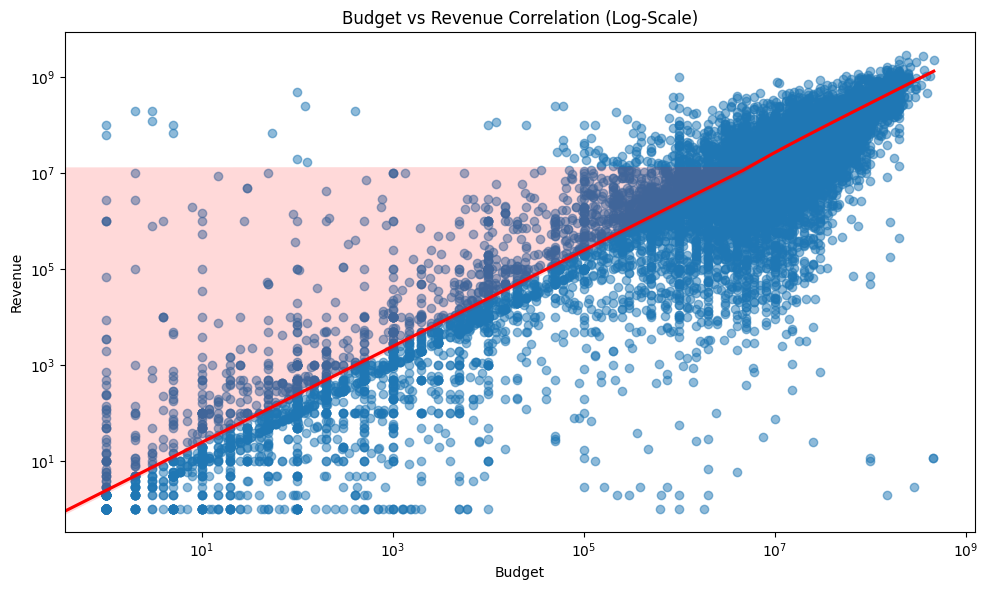

In [33]:

plt.figure(figsize=(10, 6))

sns.regplot(
    data=df,
    x='budget',
    y='revenue',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.xscale('log')
plt.yscale('log')
plt.title('Budget vs Revenue Correlation (Log-Scale)')
plt.xlabel('Budget')
plt.ylabel('Revenue')

plt.tight_layout()
plt.show()



### Visualization 2 - Top 10 Genres by Average Revenue

This bar chart displays the **top 10 movie genres ranked by their average revenue**, providing insight into which genres tend to generate the most box office success. The Y-axis uses a **logarithmic scale**, and a legend is included to help interpret values such as \(10^7 = 10\) million, \(10^8 = 100\) million, and \(10^9 = 1\) billion dollars. Among the genres, **Adventure** leads with the highest average revenue, followed closely by **Animation**, **Science Fiction**, and **Fantasy**, indicating strong commercial performance for visually immersive and franchise-driven content. Genres like **Thriller**, **Comedy**, **War**, and **Crime** appear on the lower end of the chart, suggesting they generally yield lower average returns. This graph effectively highlights genre profitability, reinforcing that high-budget, high-concept genres dominate the global box office.

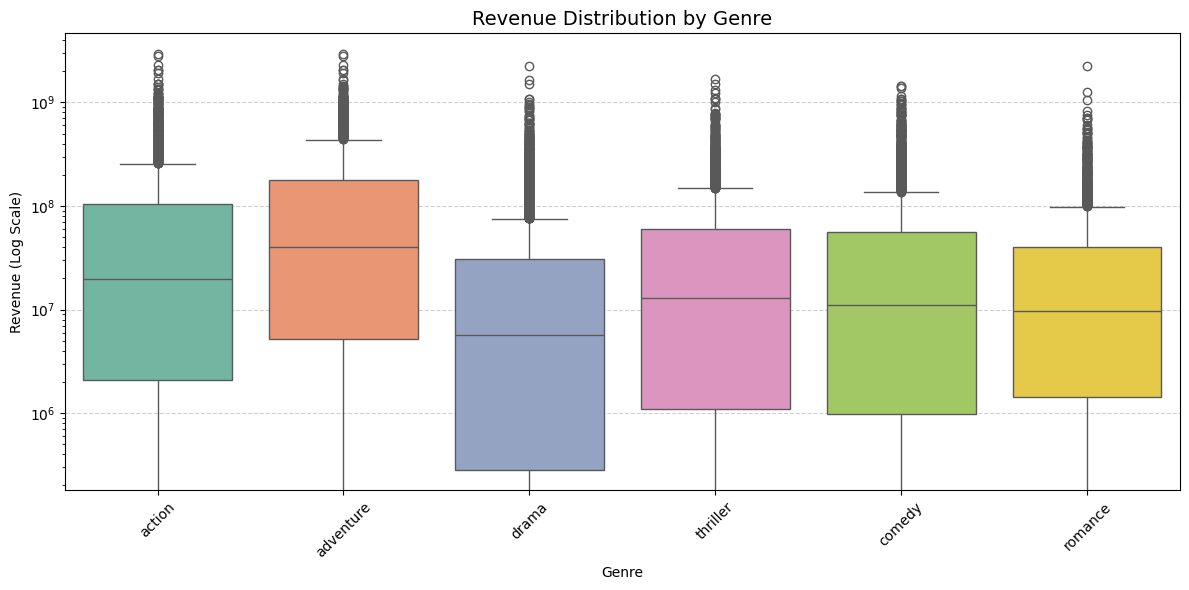

In [34]:

# Filter for top 6 popular genres
popular_genres = df.explode('genres_list')
popular_genres = popular_genres[popular_genres['genres_list'].isin(
    popular_genres['genres_list'].value_counts().head(6).index)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='genres_list',
    y='revenue',
    data=popular_genres,
    hue='genres_list', 
    palette='Set2',
    legend=False  
)


plt.yscale('log')
plt.title('Revenue Distribution by Genre', fontsize=14)
plt.xlabel('Genre')
plt.ylabel('Revenue (Log Scale)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



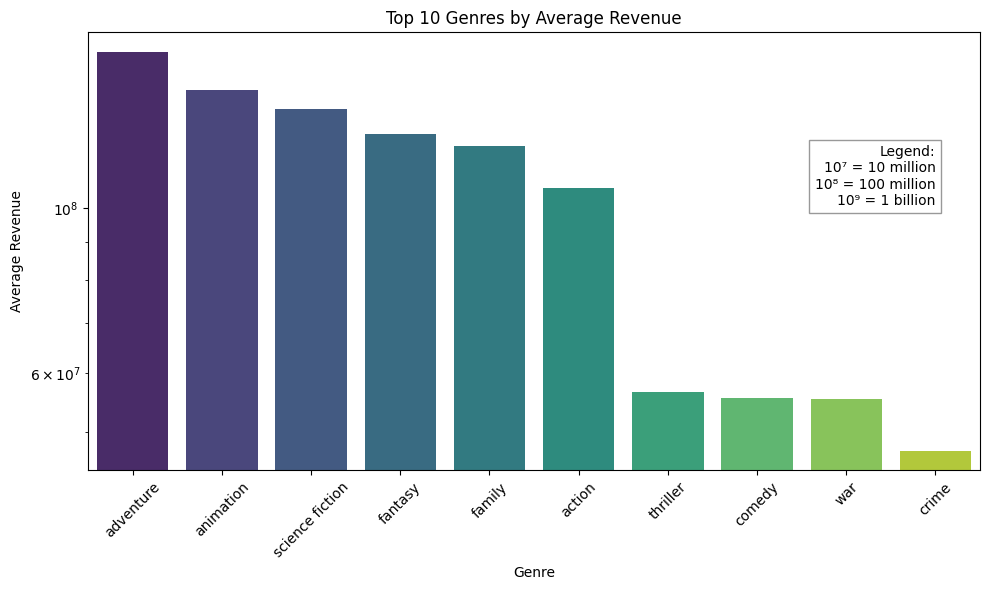

In [35]:

# Explode genre lists
genre_revenue = df.explode('genres_list')

# Compute average revenue per genre
genre_avg_revenue = genre_revenue.groupby('genres_list')['revenue'].mean().sort_values(ascending=False).head(10)

# Reset index for Seaborn
genre_avg_revenue = genre_avg_revenue.reset_index()

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=genre_avg_revenue, 
    x='genres_list', 
    y='revenue', 
    hue='genres_list', 
    palette='viridis', 
    legend=False  
)

# Customize plot
plt.yscale('log')
plt.title('Top 10 Genres by Average Revenue')
plt.ylabel('Average Revenue')
plt.xlabel('Genre')
plt.xticks(rotation=45)

# Add explanatory legend box
plt.text(
    x=9, y=1e8, 
    s='Legend:\n10⁷ = 10 million\n10⁸ = 100 million\n10⁹ = 1 billion',
    fontsize=10,
    ha='right',
    va='bottom',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.tight_layout()
plt.show()


### Visualization 3 - Number of Movies Released and Total Revenue Per year

These side-by-side line plots depict the impact of the COVID-19 pandemic on the global film industry. The **left plot** shows the number of movies released each year, while the **right plot** displays the total revenue generated annually. Both charts demonstrate a steady growth trajectory from the mid-20th century, peaking around **2018–2019**. However, the vertical red dashed line at **2019**, annotated with **“COVID-19”**, highlights a pivotal moment. Post-2019, both metrics exhibit a **dramatic decline**, reflecting the widespread disruptions caused by the pandemic, including halted productions, theater closures, and reduced box office activity. These visuals clearly illustrate how COVID-19 triggered a major downturn in movie releases and earnings after decades of consistent industry growth.

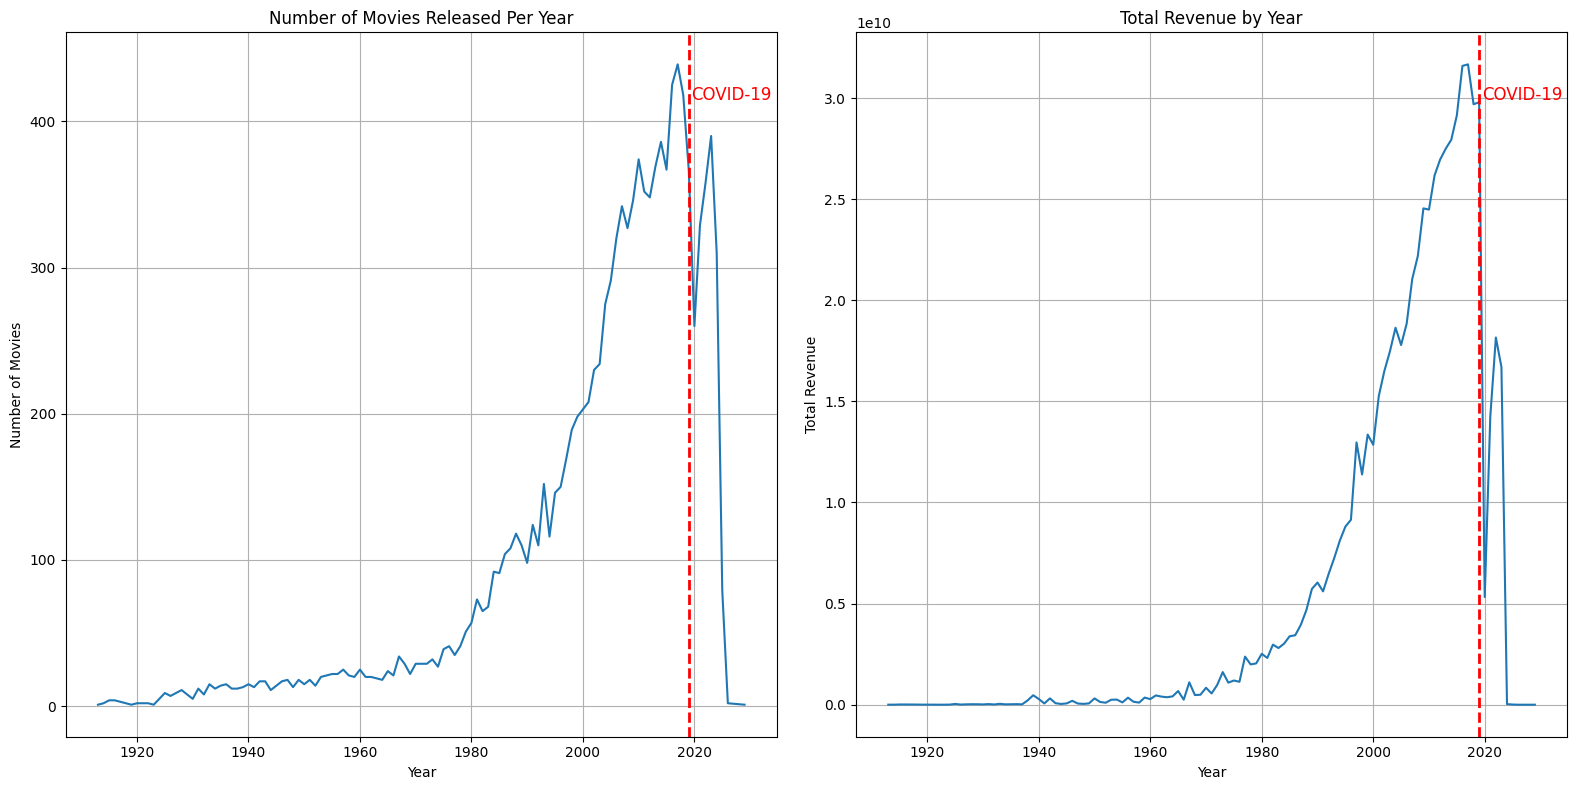

In [36]:

df['release_year'] = df['release_date'].dt.year
movies_per_year = df['release_year'].value_counts().sort_index()
revenue_per_year = df.groupby('release_year')['revenue'].sum().sort_index()

# Create subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

# Plot 1: Number of Movies Released Per Year
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, ax=axes[0])
axes[0].set_title('Number of Movies Released Per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Movies')
axes[0].axvline(x=2019, color='red', linestyle='--', linewidth=2)
axes[0].text(2019 + 0.5, axes[0].get_ylim()[1]*0.9, 'COVID-19', color='red', fontsize=12)
axes[0].grid(True)

# Plot 2: Total Revenue by Year
sns.lineplot(x=revenue_per_year.index, y=revenue_per_year.values, ax=axes[1])
axes[1].set_title('Total Revenue by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Revenue')
axes[1].axvline(x=2019, color='red', linestyle='--', linewidth=2)
axes[1].text(2019 + 0.5, axes[1].get_ylim()[1]*0.9, 'COVID-19', color='red', fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()



### Visualization 4 - Revenue Distribution by Genre

This box plot visualizes the **distribution of movie revenues** across six popular genres: Action, Adventure, Drama, Thriller, Comedy, and Romance. The Y-axis is on a **logarithmic scale**, capturing a wide range of revenue values and helping to identify patterns and outliers. Each box shows the **interquartile range (IQR)**, with the horizontal line inside representing the **median revenue**. Notably, **Adventure and Action** genres exhibit higher median revenues compared to others, suggesting stronger box office performance on average. All genres display a substantial number of **outliers**, indicating that while most films earn within a certain range, a few achieve exceptional financial success. This visualization highlights both the central tendencies and the variability in revenue performance across different movie genres.

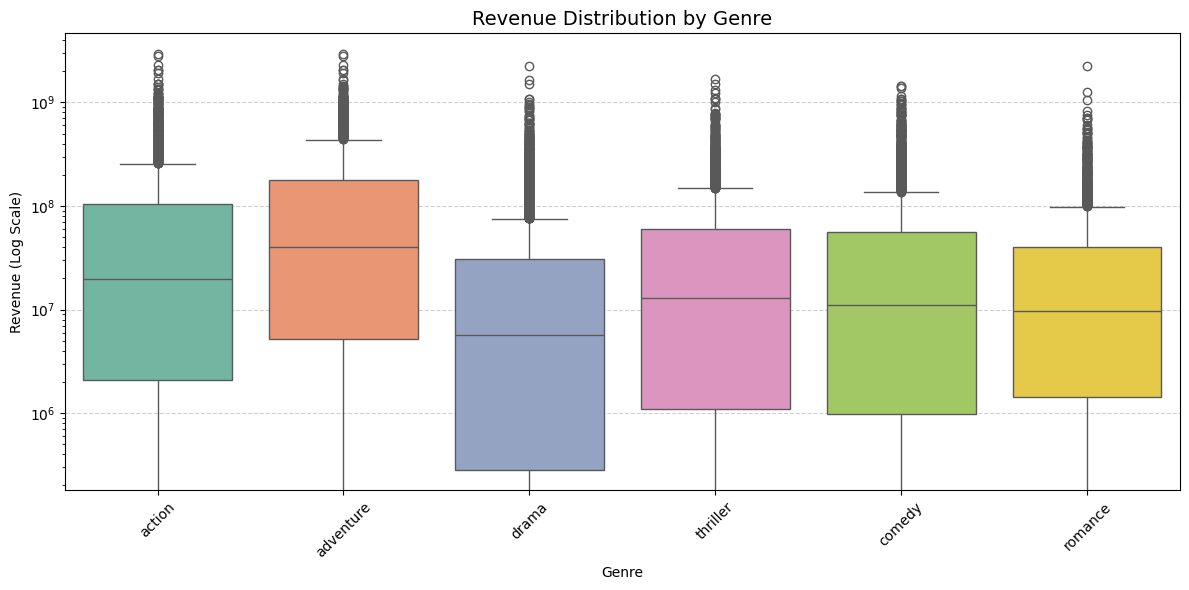

In [37]:

# Filter for top 6 popular genres
popular_genres = df.explode('genres_list')
popular_genres = popular_genres[popular_genres['genres_list'].isin(
    popular_genres['genres_list'].value_counts().head(6).index)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='genres_list',
    y='revenue',
    data=popular_genres,
    hue='genres_list', 
    palette='Set2',
    legend=False  
)


plt.yscale('log')
plt.title('Revenue Distribution by Genre', fontsize=14)
plt.xlabel('Genre')
plt.ylabel('Revenue (Log Scale)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



### Visualization 5 - Genre Trend Over the Years

From the plot, we observe that Drama has consistently been the most released genre, peaking around 2015–2019 with over 200 films per year. Comedy and Thriller also show strong upward trends, especially from the 1980s onward. Action and Adventure genres saw significant growth in the 2000s and 2010s, aligning with the rise of blockbuster cinema. Romance maintained steady popularity but started declining in the late 2010s. There is a sharp drop in all genres after 2019, clearly indicating the impact of the COVID-19 pandemic on film production globally

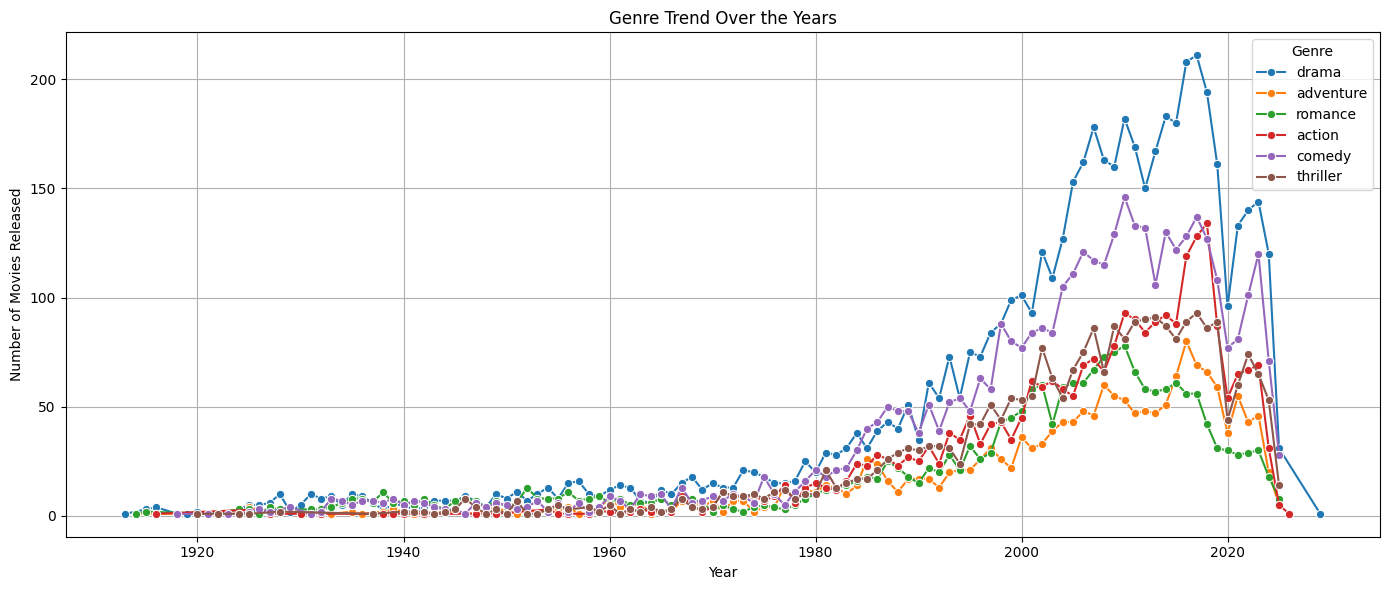

In [38]:

df['release_year'] = df['release_date'].dt.year
df_exploded = df.explode('genres_list')

# Filter to include only popular genres (optional)
top_genres = df_exploded['genres_list'].value_counts().head(6).index
df_filtered = df_exploded[df_exploded['genres_list'].isin(top_genres)]

# Group by year and genre to count number of movies
genre_trend = df_filtered.groupby(['release_year', 'genres_list']).size().reset_index(name='movie_count')

# Plot the trend
plt.figure(figsize=(14, 6))
sns.lineplot(data=genre_trend, x='release_year', y='movie_count', hue='genres_list', marker='o')

plt.title('Genre Trend Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.grid(True)
plt.legend(title='Genre')
plt.tight_layout()
plt.show()


###  Visualization 6 - Profit vs Loss by Genre

This graph presents a comparative view of **genre-wise loss and profit rates** in the film industry. The **left plot** illustrates the proportion of movies that incurred a **loss** in each genre, with *History*, *Western*, and *War* genres topping the list—indicating that a significant share of films in these categories failed to recover their budget. On the **right plot**, we see the **profit rate** for each genre, with *Family*, *Adventure*, and *Action* films showing the highest probability of turning a profit. Interestingly, genres like *Documentary*, *TV Movie*, and *History* consistently appear at the lower end of the profit spectrum and higher end of the loss spectrum, suggesting these may be riskier investments from a financial perspective. This side-by-side visualization clearly demonstrates how profitability varies by genre and can guide production or investment decisions.

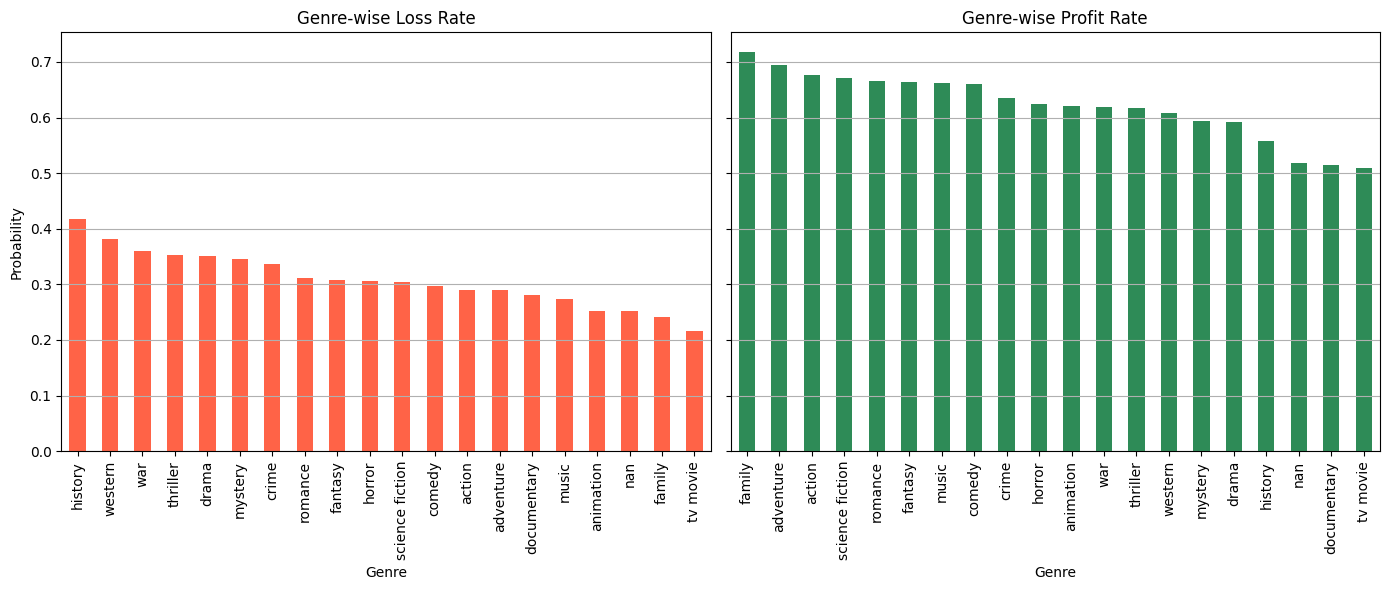

In [39]:

# Calculate profit
df['profit'] = df['revenue'] - df['budget']

# Explode genres into individual rows
df_exploded = df.explode('genres_list')

# Create loss and profit flags
df_exploded['is_loss'] = df_exploded['profit'] < 0
df_exploded['is_profit'] = df_exploded['profit'] > 0

# Calculate percentage loss and profit per genre
loss_rate = df_exploded.groupby('genres_list')['is_loss'].mean()
profit_rate = df_exploded.groupby('genres_list')['is_profit'].mean()

# Combine both into one DataFrame
rate_df = pd.DataFrame({
    'Loss Rate': loss_rate,
    'Profit Rate': profit_rate
})

rate_df_loss = rate_df.sort_values('Loss Rate', ascending=False)
rate_df_profit = rate_df.sort_values('Profit Rate', ascending=False)

# Plot side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Loss plot
rate_df_loss['Loss Rate'].plot(kind='bar', ax=axes[0], color='tomato')
axes[0].set_title('Genre-wise Loss Rate')
axes[0].set_ylabel('Probability')
axes[0].set_xlabel('Genre')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y')

# Profit plot
rate_df_profit['Profit Rate'].plot(kind='bar', ax=axes[1], color='seagreen')
axes[1].set_title('Genre-wise Profit Rate')
axes[1].set_xlabel('Genre')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


###  Visualization 7 - Top 20 actors on average revenue-to-budget ratio

From the plot, we can see Robert Shaw, Lin Shaye, and Shawnee Smith stand out with high average revenues, indicating that the movies they participated in typically generated substantial returns compared to their budgets. Olivia de Havilland and Clark Gable also show strong positive returns on relatively modest budgets. Several actors in the lower-left corner (e.g., Margaret Hamilton, Steve Landesberg) had low average budgets and revenues, suggesting lower overall commercial impact, but they still made the top 20 due to high revenue-to-budget efficiency in smaller productions.

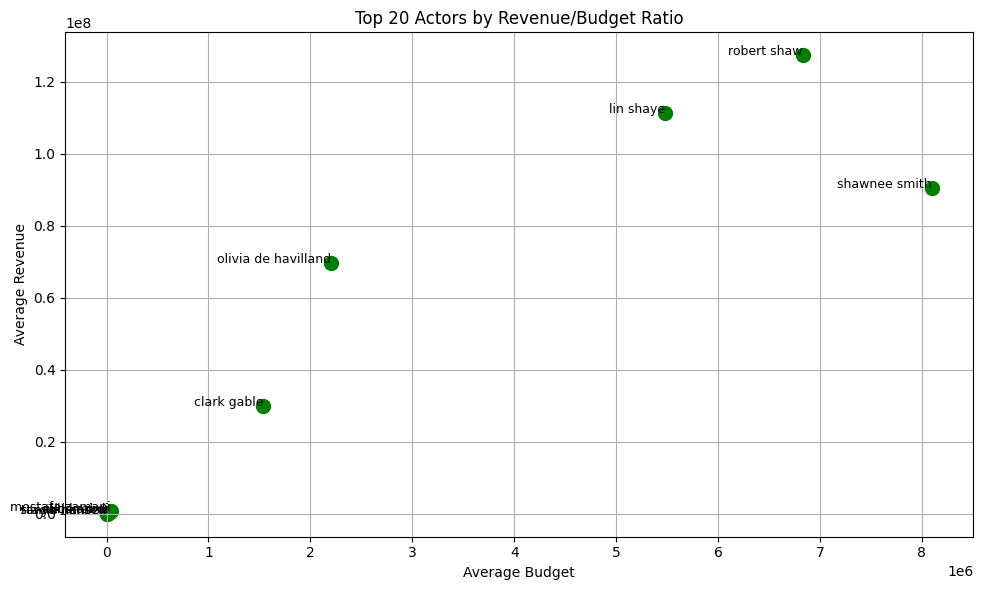

In [40]:

# Explode top_cast_list
df_exploded = df.explode('top_cast_list')

actor_avg = df_exploded.groupby('top_cast_list').agg(
    avg_budget=('budget', 'mean'),
    avg_revenue=('revenue', 'mean'),
    movie_count=('budget', 'count')
)

# Filter to only actors with 5+ movies to avoid outliers
actor_avg = actor_avg[actor_avg['movie_count'] >= 5]

actor_avg['ratio'] = actor_avg['avg_revenue'] / actor_avg['avg_budget']
top10 = actor_avg.sort_values('ratio', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.scatter(top10['avg_budget'], top10['avg_revenue'], color='green', s=100)

for actor, row in top10.iterrows():
    plt.text(row['avg_budget'], row['avg_revenue'], actor, fontsize=9, ha='right')

plt.xlabel('Average Budget')
plt.ylabel('Average Revenue')
plt.title('Top 20 Actors by Revenue/Budget Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()


###  Visualization 8 -  Trends of average budget, revenue, and profit 

This line plot visualizes the trends of average budget, revenue, and profit for movies over the years from 1950 to 2022. Each line represents the yearly average for one financial metric—budget (blue), revenue (orange), and profit (green)—with shaded areas indicating variance (standard error). The Y-axis is on a logarithmic scale to accommodate the wide range of dollar amounts.

From the graph, we can observe A consistent upward trend in budget and revenue from the 1980s to the late 2010s, reflecting inflation and the rise of big-budget blockbusters. Profit (revenue minus budget) also follows a similar upward trend, peaking shortly before 2020. A sharp drop in all three metrics occurs around 2020, signaling the impact of the COVID-19 pandemic on film production and box office performance.

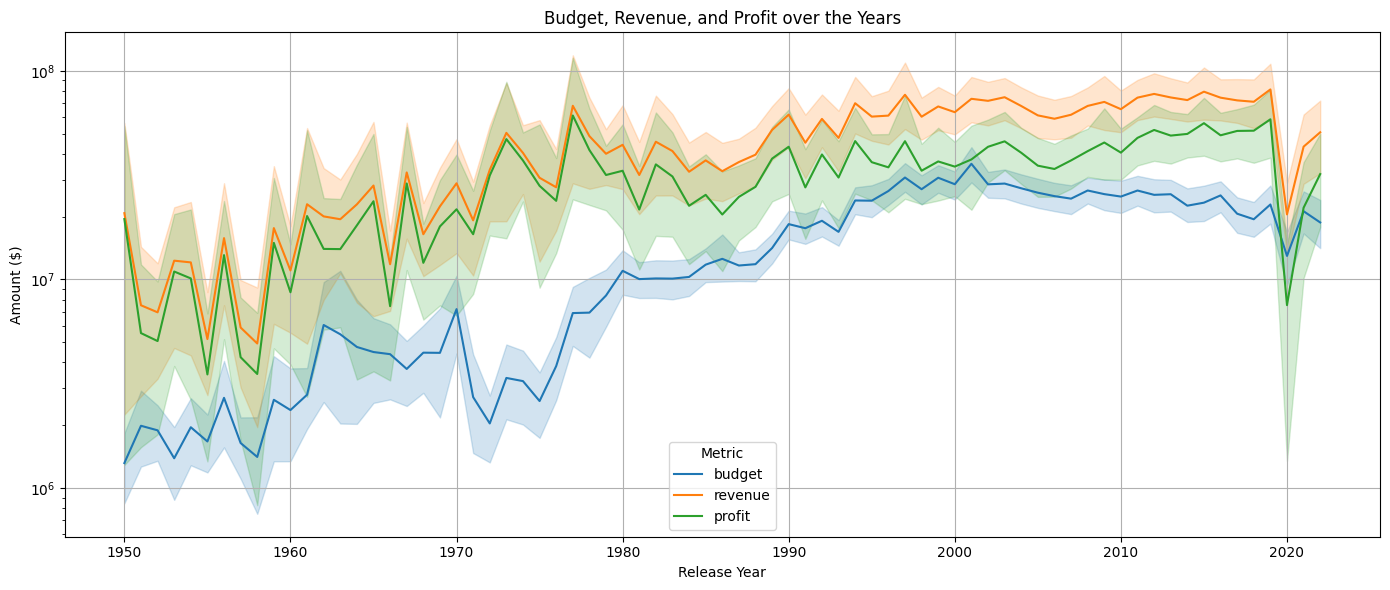

In [41]:

df['release_year'] = df['release_date'].dt.year
df['profit'] = df['revenue'] - df['budget']
df_filtered = df[(df['release_year'] >= 1950) & (df['release_year'] <= 2022)]

# Melt data into long format for seaborn
melted_df = df_filtered.melt(id_vars='release_year', value_vars=['budget', 'revenue', 'profit'],
                             var_name='Metric', value_name='Amount')

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=melted_df, x='release_year', y='Amount', hue='Metric')
plt.title('Budget, Revenue, and Profit over the Years')
plt.xlabel('Release Year')
plt.ylabel('Amount ($)')
plt.yscale('log')  # optional for better visibility of scale differences
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualization 9 - correlation heatmap for the numerical features, specifically budget, revenue, vote_average, popularity, and vote_count.
Strong positive correlation (closer to 1), no correlation (0), strong negative correlation (closer to -1)

From the plot, we can see:

- Popularity and vote count are the strongest indicators of revenue.
- Budget matters a lot — it correlates with both revenue and popularity.
- High vote average doesn’t guarantee commercial success — critically acclaimed ≠ box office hit.
- Runtime is the least impactful among these features.The popularity score isn't strongly determined by runtime. However, very short movies (< 60 min) tend to have low popularity,

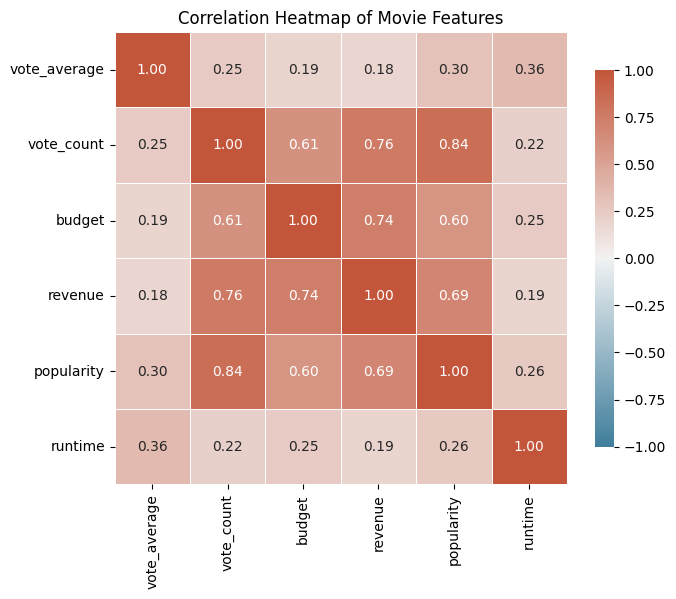

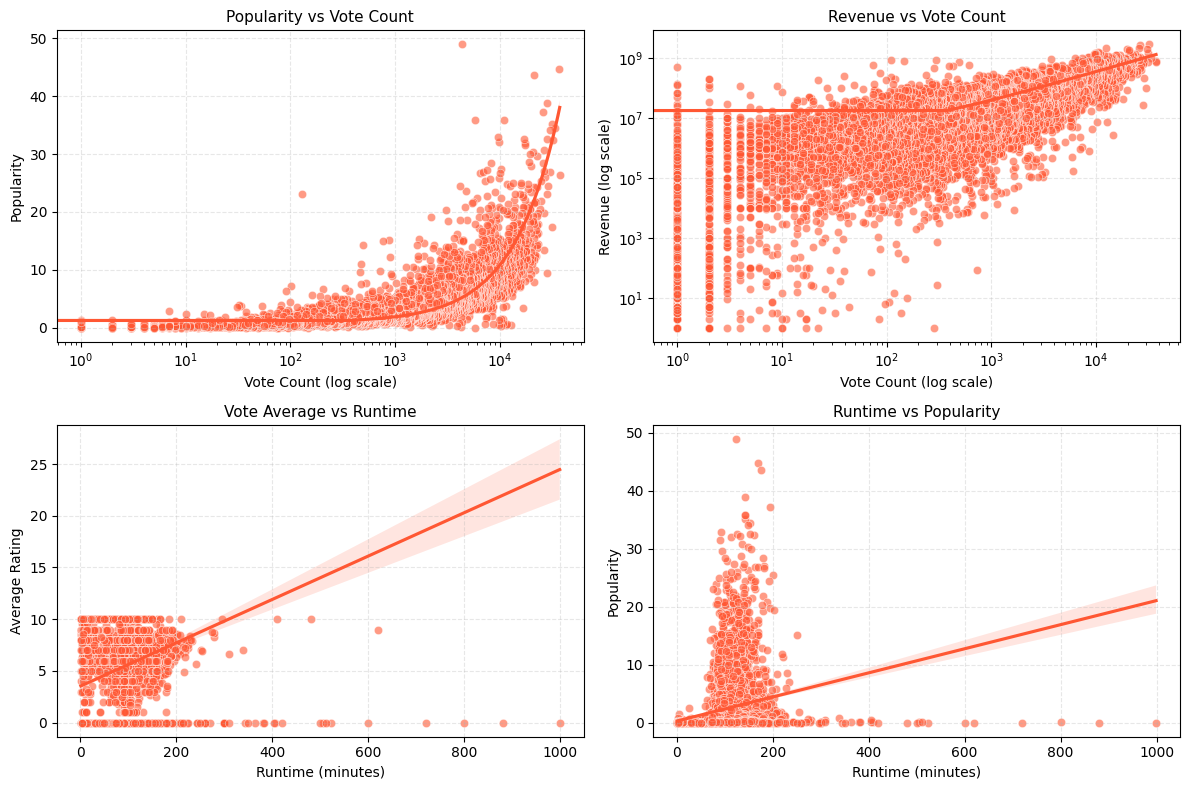

In [42]:
# numerical columns for correlation
numerical_features = ['vote_average', 'vote_count', 'budget', 'revenue', 'popularity', 'runtime']

# Correlation matrix Calculation
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(7, 6))

# Custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, 
            annot=True,           # Show the correlation values
            fmt='.2f',            # Format to 2 decimal places
            cmap=cmap,            # Custom colormap
            vmax=1.0,             # Maximum correlation value
            vmin=-1.0,            # Minimum correlation value
            center=0,             # Center the colormap at zero
            square=True,          # Make the cells square
            linewidths=.5,        # Width of the lines between cells
            cbar_kws={"shrink": .8})  # Size of colorbar

#title
plt.title('Correlation Heatmap of Movie Features')
plt.tight_layout()
plt.show()




# Sub-plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# 1. Popularity vs Vote Count (log X)
sns.scatterplot(data=df, x='vote_count', y='popularity', color='#FF5733', alpha=0.6, edgecolor='w', ax=axes[0, 0])
sns.regplot(data=df, x='vote_count', y='popularity', scatter=False, color='#FF5733', ax=axes[0, 0])
axes[0, 0].set_xscale('log')
axes[0, 0].set_title('Popularity vs Vote Count', fontsize=11)
axes[0, 0].set_xlabel('Vote Count (log scale)')
axes[0, 0].set_ylabel('Popularity')
axes[0, 0].grid(True, linestyle='--', alpha=0.3)

# 2. Revenue vs Vote Count (log-log)
sns.scatterplot(data=df, x='vote_count', y='revenue', color='#FF5733', alpha=0.6, edgecolor='w', ax=axes[0, 1])
sns.regplot(data=df, x='vote_count', y='revenue', scatter=False, color='#FF5733', ax=axes[0, 1])
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Revenue vs Vote Count', fontsize=11)
axes[0, 1].set_xlabel('Vote Count (log scale)')
axes[0, 1].set_ylabel('Revenue (log scale)')
axes[0, 1].grid(True, linestyle='--', alpha=0.3)

# 3. Vote Average vs Runtime (linear)
sns.scatterplot(data=df, x='runtime', y='vote_average', color='#FF5733', alpha=0.6, edgecolor='w', ax=axes[1, 0])
sns.regplot(data=df, x='runtime', y='vote_average', scatter=False, color='#FF5733', ax=axes[1, 0])
axes[1, 0].set_title('Vote Average vs Runtime', fontsize=11)
axes[1, 0].set_xlabel('Runtime (minutes)')
axes[1, 0].set_ylabel('Average Rating')
axes[1, 0].grid(True, linestyle='--', alpha=0.3)

# 4. Runtime vs Popularity (NEW)
sns.scatterplot(data=df, x='runtime', y='popularity', color='#FF5733', alpha=0.6, edgecolor='w', ax=axes[1, 1])
sns.regplot(data=df, x='runtime', y='popularity', scatter=False, color='#FF5733', ax=axes[1, 1])
axes[1, 1].set_title('Runtime vs Popularity', fontsize=11)
axes[1, 1].set_xlabel('Runtime (minutes)')
axes[1, 1].set_ylabel('Popularity')
axes[1, 1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()




### Visualization 10 - bar chart showing movie revenues by release month

From the plot, we can see:

- June leads with $88.69B, clearly marked with a bold color and **SUMMER** annotation, summer is typically when blockbusters are released (e.g., Marvel
movies, big-budget sequels), so this aligns with industry trends.
- January shows the lowest return: $23.89B, marked with hatching. This reflects the industry pattern — January is often a dump month where studios release lower-priority films post-holiday season.
- A red horizontal line shows the average monthly revenue: ~$55.91B
- Summer (May–July): Dominates the box office — all 3 months are above average, December (HOLIDAY): Also performs extremely well — second only to June.

- Winter (Jan–Feb): Low performance months, likely due to post-holiday drop and lack of major releases.

- Fall (Sep–Nov): Mixed — September is modest, while October and November perform better (possibly due to pre-Oscar releases and holiday hype).
        


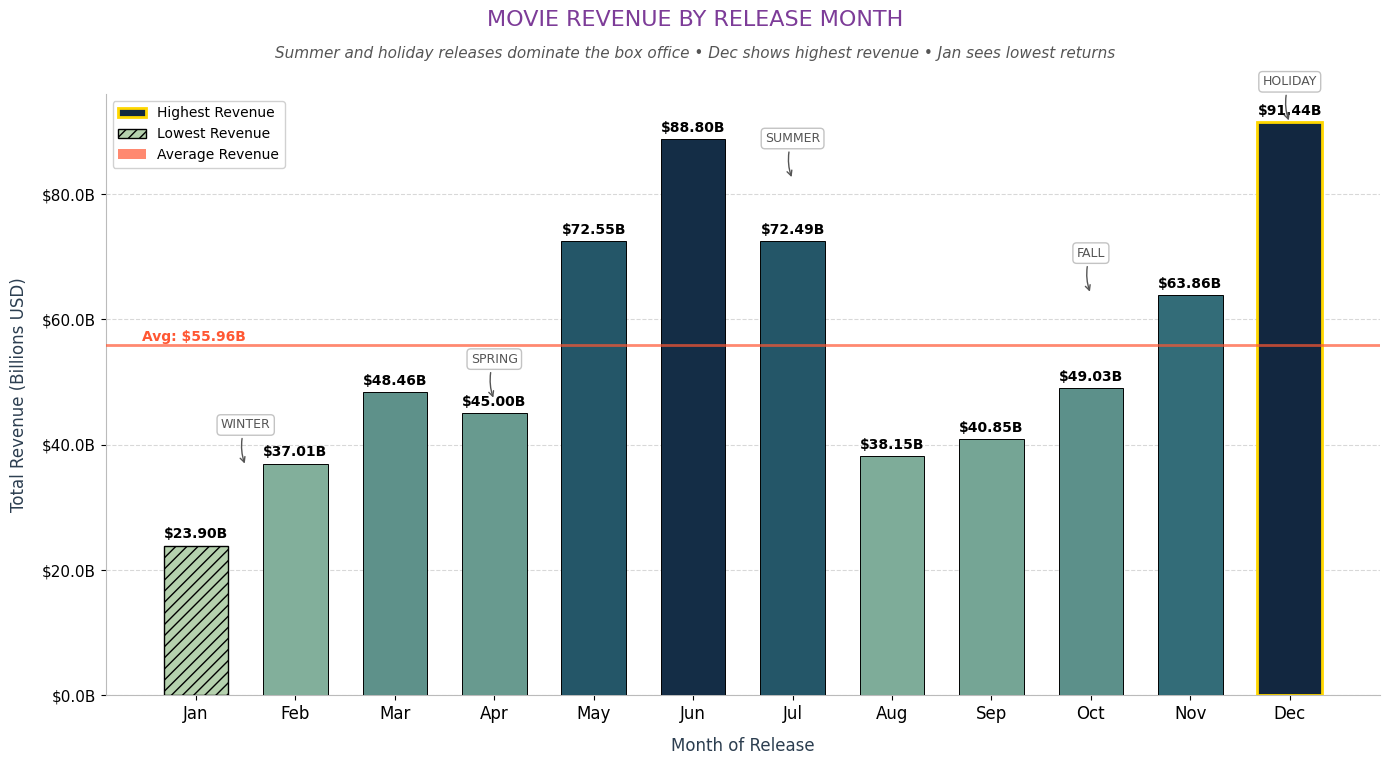

In [43]:
import calendar
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from matplotlib.patches import Patch


df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date'])

df['month_num'] = df['release_date'].dt.month.astype(int)

# Grouping and summarizing revenue
month_revenue = df.groupby('month_num')['revenue'].sum().reset_index()
month_revenue['month_name'] = month_revenue['month_num'].apply(lambda x: calendar.month_abbr[x])
month_revenue.sort_values('month_num', inplace=True)

# ---------------------------
# 1)  Teal palette
# ---------------------------
teal_colors = [
    '#b5d1ae',  # Teal 1 (lightest)
    '#80ae9a',  # Teal 2
    '#568b87',  # Teal 3
    '#326b77',  # Teal 4
    '#1b485e',  # Teal 5
    '#122740'   # Teal 6 (darkest)
]

# A couple of helper functions to do gradient interpolation:
def hex_to_rgb(hex_color):
    """Convert hex string (e.g. '#568b87') to an (r,g,b) tuple scaled [0..1]."""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))

def rgb_to_hex(rgb_tuple):
    """Convert an (r,g,b) tuple scaled [0..1] back to a hex string."""
    return '#{:02x}{:02x}{:02x}'.format(
        int(round(rgb_tuple[0]*255)),
        int(round(rgb_tuple[1]*255)),
        int(round(rgb_tuple[2]*255))
    )

def interpolate_color(val, min_val, max_val, palette):
    """
    Interpolates a color from the given palette based on val's position
    between min_val and max_val. The palette is a list of hex colors
    going from lighter to darker teal.
    """
    if max_val == min_val:
        # Avoid division-by-zero if all values are the same
        return palette[-1]
    
    # Normalize fraction between 0 and 1
    fraction = (val - min_val) / (max_val - min_val)
    fraction *= (len(palette) - 1)
    
    idx_floor = int(np.floor(fraction))
    idx_ceil = min(idx_floor + 1, len(palette) - 1)
    local_frac = fraction - idx_floor
    
    c1 = hex_to_rgb(palette[idx_floor])
    c2 = hex_to_rgb(palette[idx_ceil])
    
    # Linear interpolate between two adjacent colors
    r = c1[0] + (c2[0] - c1[0]) * local_frac
    g = c1[1] + (c2[1] - c1[1]) * local_frac
    b = c1[2] + (c2[2] - c1[2]) * local_frac
    
    return rgb_to_hex((r, g, b))

# -------------------------------
# 2) Assign a color to each month
# -------------------------------
min_rev = month_revenue['revenue'].min()
max_rev = month_revenue['revenue'].max()

bar_colors = [
    interpolate_color(rev, min_rev, max_rev, teal_colors)
    for rev in month_revenue['revenue']
]

# ---------------------------
# 3) Plot with the new colors
# ---------------------------
fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
ax.set_facecolor('white')

x = np.arange(len(month_revenue['month_name']))
bar_width = 0.65

bars = ax.bar(
    x, 
    month_revenue['revenue'] / 1e9,  # Convert to billions
    width=bar_width,
    color=bar_colors,
    edgecolor='black',
    linewidth=0.7,
    zorder=3
)

# Enhanced grid
ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray', zorder=0)

# Highest and lowest revenue months
max_idx = month_revenue['revenue'].idxmax()
min_idx = month_revenue['revenue'].idxmin()

# Outline the highest bar in gold
bars[max_idx].set_edgecolor('gold')
bars[max_idx].set_linewidth(2)

# Hatch the lowest bar
bars[min_idx].set_hatch('///')
bars[min_idx].set_linewidth(1.0)

# Adding a horizontal average line
avg_revenue = month_revenue['revenue'].mean() / 1e9
ax.axhline(y=avg_revenue, color='#FF5733', linestyle='-', alpha=0.7, zorder=4, linewidth=2)
ax.text(
    0.5, avg_revenue + 0.1, 
    f'Avg: ${avg_revenue:.2f}B', 
    ha='right', va='bottom', color='#FF5733', 
    fontweight='bold'
)

# Annotate each bar with revenue value
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.annotate(
        f'${height:.2f}B',
        xy=(bar.get_x() + bar.get_width()/2, height),
        xytext=(0, 3),
        textcoords='offset points',
        ha='center', va='bottom',
        fontsize=10, fontweight='bold',
        color='black'
    )

# Title and labels
plt.title("", fontsize=22, weight='bold', color='#2C3E50', loc='center', pad=20)
plt.suptitle("MOVIE REVENUE BY RELEASE MONTH", fontsize=16, color='#7D3C98', y=0.95)

ax.set_xlabel("Month of Release", fontsize=12, labelpad=10, color='#2C3E50')
ax.set_ylabel("Total Revenue (Billions USD)", fontsize=12, labelpad=10, color='#2C3E50')

ax.set_xticks(x)
ax.set_xticklabels(month_revenue['month_name'], fontsize=12)
ax.tick_params(axis='y', labelsize=11)

# Formatting y-axis with dollar signs
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:.1f}B'))

# Custom legend
legend_elements = [
    Patch(facecolor=bars[max_idx].get_facecolor(), edgecolor='gold', linewidth=2, label='Highest Revenue'),
    Patch(facecolor=bars[min_idx].get_facecolor(), edgecolor='black', hatch='///', label='Lowest Revenue'),
    Patch(facecolor='#FF5733', alpha=0.7, label='Average Revenue')
]
ax.legend(handles=legend_elements, loc='best', frameon=True, framealpha=0.9)

# Adding a subtitle with analysis
highest_month = month_revenue.iloc[max_idx]['month_name']
lowest_month = month_revenue.iloc[min_idx]['month_name']
fig.text(
    0.5, 0.89, 
    f"Summer and holiday releases dominate the box office • {highest_month} shows highest revenue • {lowest_month} sees lowest returns",
    ha='center', fontsize=11, style='italic', color='#555555'
)

# Adding film strip decorative elements (optional – can remove if you like)
for i in range(8):
    x_pos = -0.8 + i * 0.4
    rect = plt.Rectangle((x_pos, -0.8), 0.25, 0.3, facecolor='black', alpha=0.8, transform=ax.transAxes)
    ax.add_patch(rect)
    
    x_pos = 0.7 + i * 0.4
    rect = plt.Rectangle((x_pos, -0.8), 0.25, 0.3, facecolor='black', alpha=0.8, transform=ax.transAxes)
    ax.add_patch(rect)

# Adding annotations for seasons (optional)
season_spans = [
    ((0, 1), "WINTER", 0.4),
    ((2, 4), "SPRING", 0.515),
    ((5, 7), "SUMMER", 0.9),
    ((8, 10), "FALL", 0.7),
    ((11, 11), "HOLIDAY", 0.999)
]

for (start, end), label, y_pos in season_spans:
    middle = (start + end) / 2
    ax.annotate(
        label,
        xy=(middle, y_pos * month_revenue['revenue'].max() / 1e9),
        xytext=(0, 25),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color='#555555'),
        ha='center', va='bottom',
        fontsize=9, color='#555555',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7, edgecolor='#aaaaaa')
    )

# Styling the spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#bbbbbb')
ax.spines['bottom'].set_color('#bbbbbb')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


